Elbow Method: 100%|██████████| 18/18 [00:08<00:00,  2.07it/s]


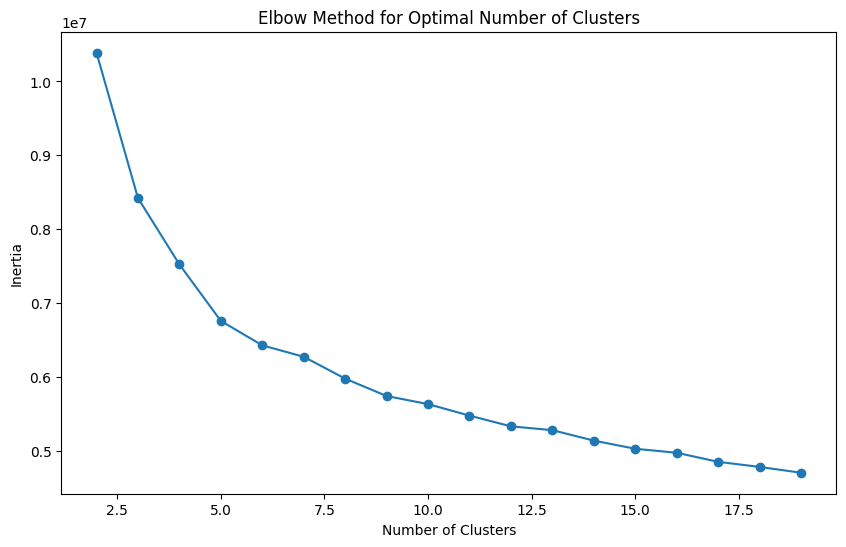

Silhouette Score: 100%|██████████| 18/18 [00:12<00:00,  1.43it/s]


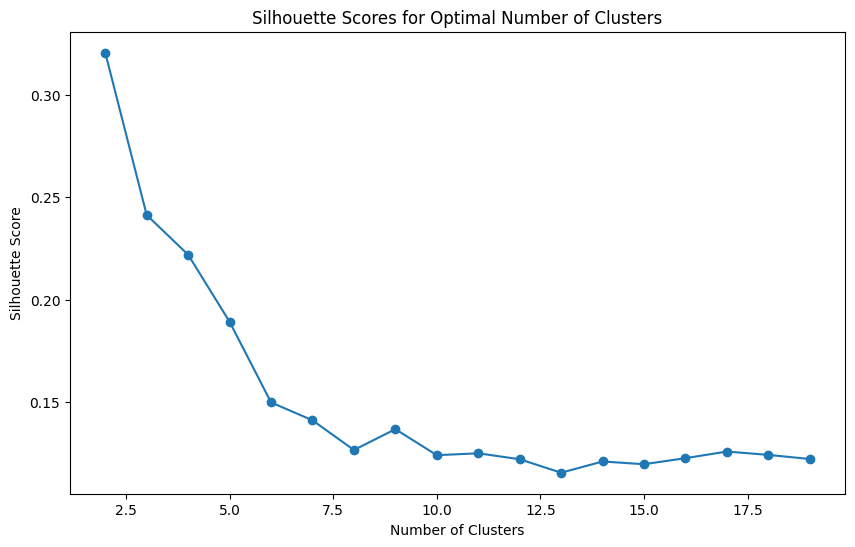

Calculating Group Correlations: 100%|██████████| 4128/4128 [00:00<00:00, 5452.40it/s]


Correlations saved to 'Correlations.parquet'.


In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import multiprocessing as mp

data_dir = 'Data/PriceData'

# Load Parquet files into data_frames dictionary
data_frames = {}
files = [file for file in os.listdir(data_dir) if file.endswith('.parquet')]
for file in tqdm(files, desc="Loading Parquet files"):
    ticker = file.split('.')[0]
    data_frames[ticker] = pd.read_parquet(os.path.join(data_dir, file))

def calculate_returns(df):
    df['Return'] = df['Close'].pct_change()
    return df

for ticker, df in tqdm(data_frames.items(), desc="Calculating Returns"):
    data_frames[ticker] = calculate_returns(df)

returns_df = pd.DataFrame({ticker: df['Return'] for ticker, df in data_frames.items()}).dropna(how='all')

correlation_matrix = returns_df.corr()

imputer = SimpleImputer(strategy='mean')
imputed_correlation = imputer.fit_transform(correlation_matrix)

scaler = StandardScaler()
scaled_correlation = scaler.fit_transform(imputed_correlation)

kmeans = KMeans(n_clusters=8, random_state=0)
clusters = kmeans.fit_predict(scaled_correlation)

correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df['Cluster'] = clusters

inertia = []
for k in tqdm(range(2, 20), desc="Elbow Method"):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_correlation)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

silhouette_scores = []
for k in tqdm(range(2, 20), desc="Silhouette Score"):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(scaled_correlation)
    silhouette_scores.append(silhouette_score(scaled_correlation, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.show()

clustered_assets = correlation_matrix_df[['Cluster']].reset_index()
clustered_assets.columns = ['Ticker', 'Cluster']

def calculate_group_correlations(ticker):
    group_correlations = {}
    for group in sorted(clustered_assets['Cluster'].unique()):  # Ensure the clusters are processed in order
        tickers_in_group = clustered_assets[clustered_assets['Cluster'] == group]['Ticker']
        group_corr = correlation_matrix.loc[ticker, tickers_in_group].mean()
        group_correlations[f'correlation_{group}'] = group_corr
    return ticker, group_correlations

group_corr_columns = [f'correlation_{group}' for group in sorted(clustered_assets['Cluster'].unique())]
for col in group_corr_columns:
    clustered_assets[col] = np.nan

if __name__ == "__main__":
    tickers = clustered_assets['Ticker'].unique()
    
    with mp.Pool(mp.cpu_count()) as pool:
        results = list(tqdm(pool.imap(calculate_group_correlations, tickers), total=len(tickers), desc="Calculating Group Correlations"))

    for ticker, group_correlations in results:
        for col, value in group_correlations.items():
            clustered_assets.loc[clustered_assets['Ticker'] == ticker, col] = value

    mean_intra_group_corr = clustered_assets.groupby('Cluster')[group_corr_columns].mean().mean(axis=1)
    clustered_assets['mean_intragroup_correlation'] = clustered_assets['Cluster'].map(mean_intra_group_corr)
    clustered_assets['diff_to_mean_group_corr'] = clustered_assets.apply(lambda row: row[f'correlation_{row.Cluster}'] - row['mean_intragroup_correlation'], axis=1)

    reordered_columns = ['Ticker', 'Cluster', 'mean_intragroup_correlation', 'diff_to_mean_group_corr'] + group_corr_columns
    clustered_assets = clustered_assets[reordered_columns]

    clustered_assets = clustered_assets.round(5)
    clustered_assets.to_parquet('Correlations.parquet', index=False)

print("Correlations saved to 'Correlations.parquet'.")


In [2]:
import os
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

def convert_csv_to_parquet(file_path):
    """
    Convert a CSV file to Parquet format.
    
    Args:
    file_path (str): Path to the CSV file to be converted.
    """
    try:
        df = pd.read_csv(file_path)
        parquet_file_path = file_path.replace('.csv', '.parquet')
        df.to_parquet(parquet_file_path, index=False)
        return parquet_file_path
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def process_files_in_directory(input_directory):
    """
    Process all CSV files in the input directory and convert them to Parquet format.
    
    Args:
    input_directory (str): Path to the input directory containing CSV files.
    """
    # Find all CSV files in the directory
    csv_files = [os.path.join(input_directory, f) for f in os.listdir(input_directory) if f.endswith('.csv')]
    
    # Initialize progress bar and multiprocessing pool
    with ProcessPoolExecutor() as executor:
        results = list(tqdm(executor.map(convert_csv_to_parquet, csv_files), total=len(csv_files), desc="Converting CSV to Parquet"))

    print(f"Converted {len(results)} files to Parquet format.")

# Example usage in a Jupyter Notebook
input_directory = 'Data/RFpredictions'  # Change this to your input directory
#process_files_in_directory(input_directory)




def delete_csv_files(input_directory):

    csv_files = [os.path.join(input_directory, f) for f in os.listdir(input_directory) if f.endswith('.csv')]
    
    for csv_file in csv_files:
        os.remove(csv_file)
    
    print(f"Deleted {len(csv_files)} CSV files.")

delete_csv_files(input_directory)



Deleted 0 CSV files.
